In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Известны данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.



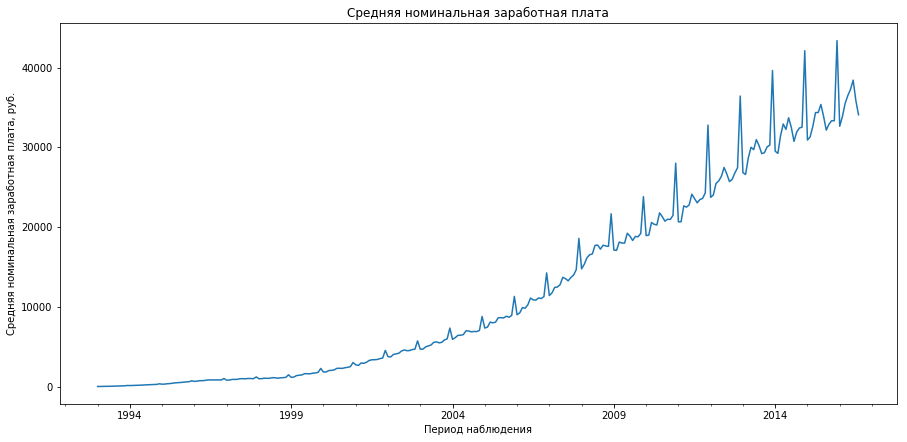

In [61]:
money = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
money.WAG_C_M.plot()
plt.ylabel(u'Средняя номинальная заработная плата, руб.')
plt.xlabel(u'Период наблюдения')
plt.title(u'Средняя номинальная заработная плата')
pylab.show()

# Визуальный анализ ряда


В ряду есть тренд, сезонная цикличность, различная дисперсия

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

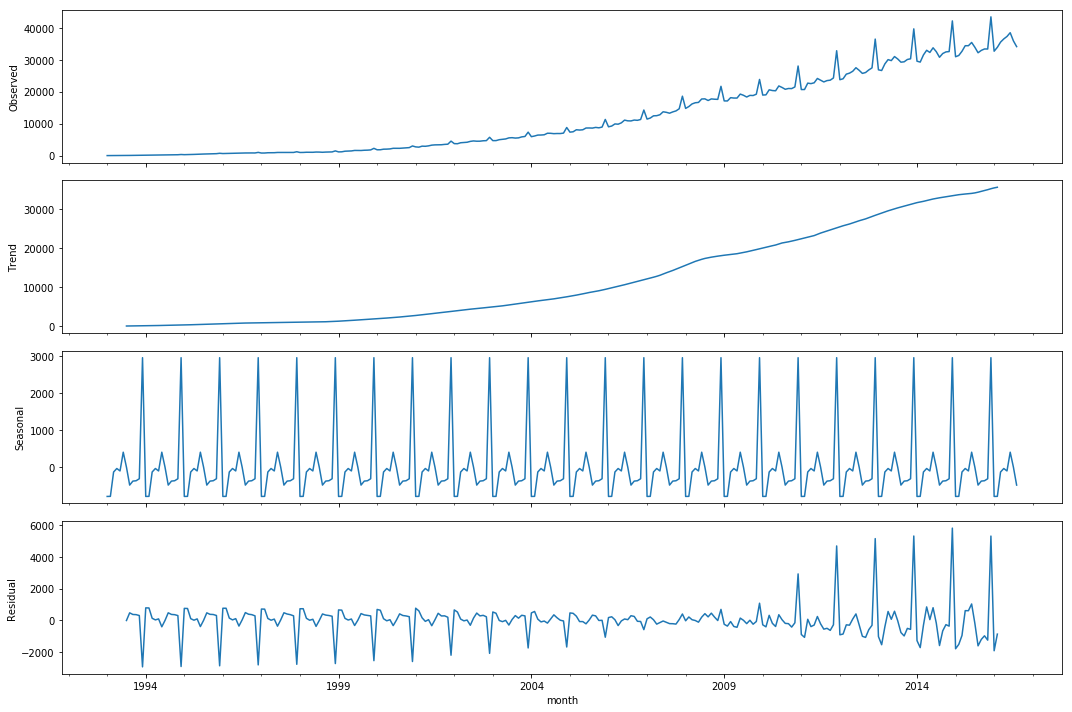

In [6]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(money.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(money.WAG_C_M)[1])

Видно, что критерий Дикки-Фуллера дает уровень значимости 0.99. мы не можем отвергнуть нулевую гипотезу о нестационарности ряда.



Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


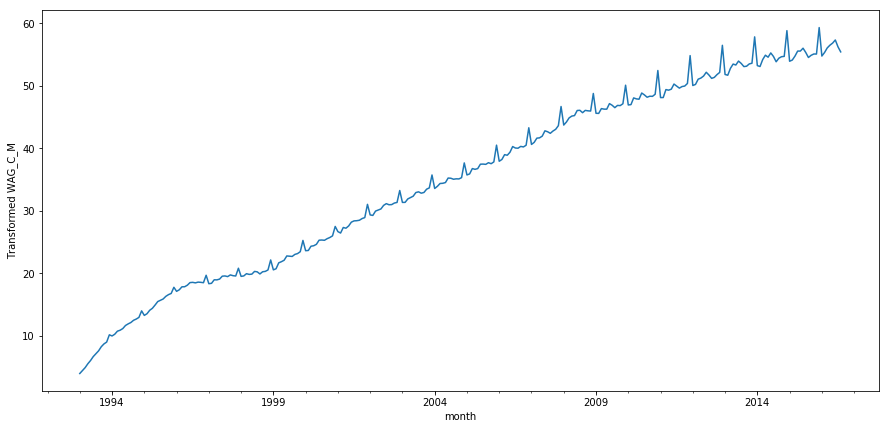

In [62]:
money['WAG_C_M_box'], lmbda = stats.boxcox(money.WAG_C_M)
plt.figure(figsize(15,7))
money.WAG_C_M_box.plot()
plt.ylabel(u'Transformed WAG_C_M')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(money.WAG_C_M_box)[1])

Дисперсия уменьшилась, но остался тренд. И критерий Дики-Фуллера не выполнен. Осталась сезонность

Проведем сначала сезонное дифференцирование и посмотрим на результат:


Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

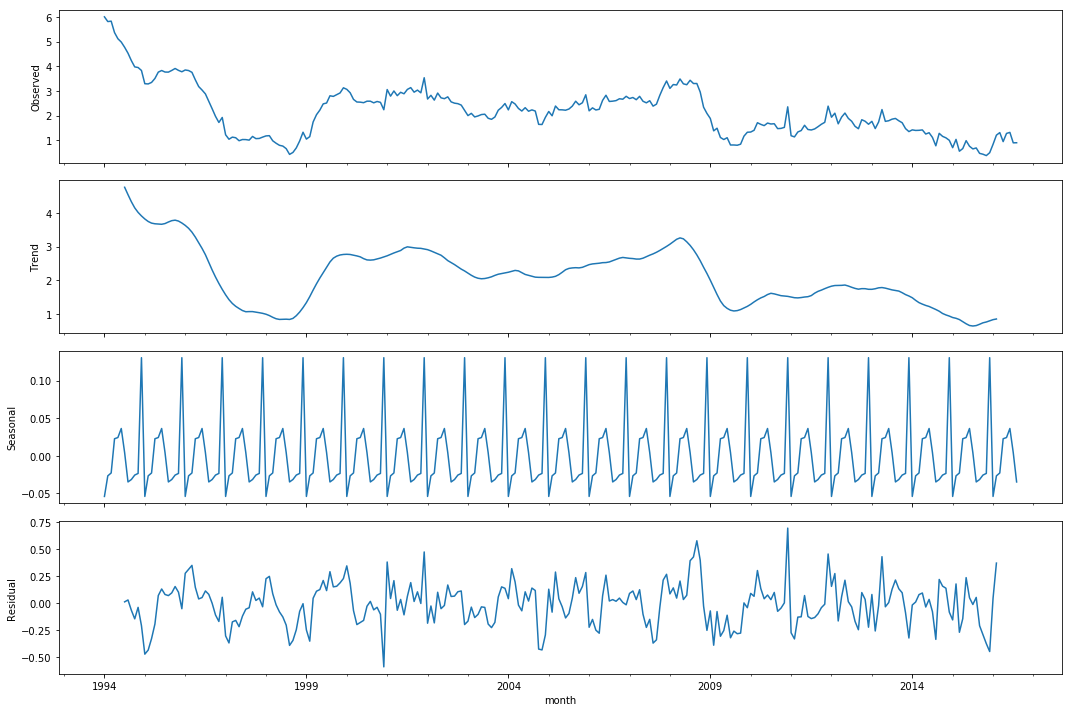

In [10]:
money['WAG_C_M_box_diff'] = money.WAG_C_M_box - money.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(money.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(money.WAG_C_M_box_diff[12:])[1])

Критерий Дики-Фуллера дает уровень значимоссти 0.014697 и отвергает гипотезу о нестационарности. Dсе еще заметен тренд, поэтому попробуем добавить еще обычное дифференцирование:



Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

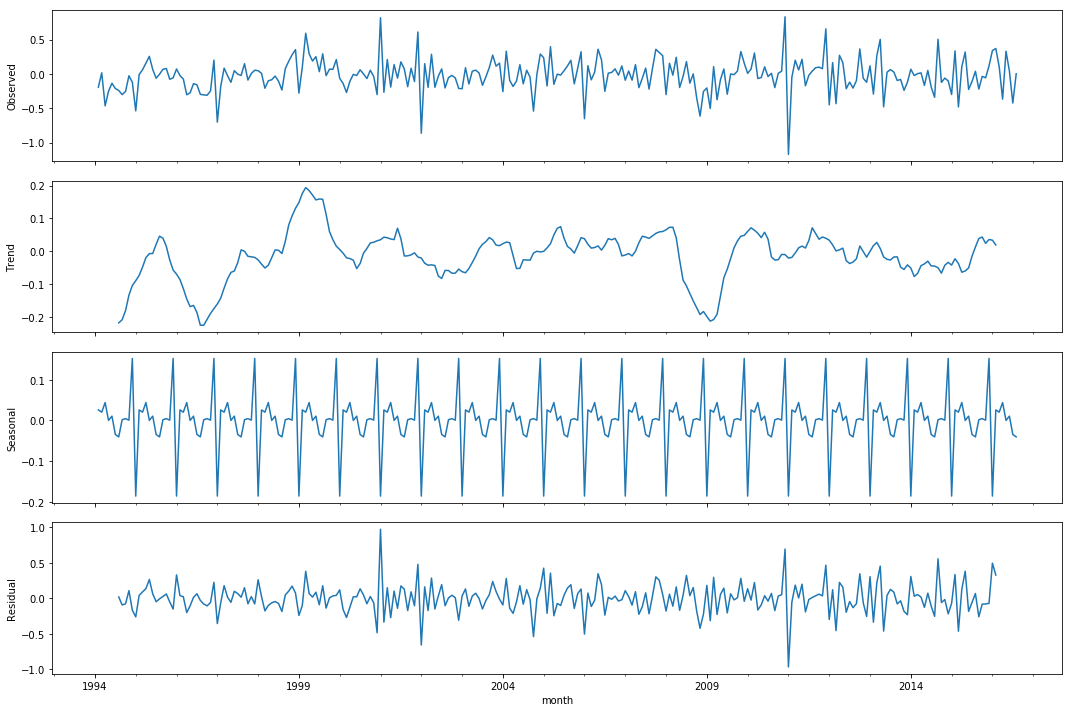

In [11]:
money['WAG_C_M_box_diff2'] = money.WAG_C_M_box_diff - money.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(money.WAG_C_M_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(money.WAG_C_M_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

# Подбор модели.
Построим графики автокорреляции и частичной автокорреляции для полученного ряда:



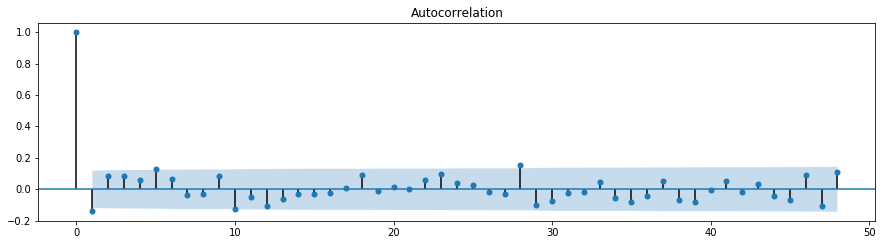

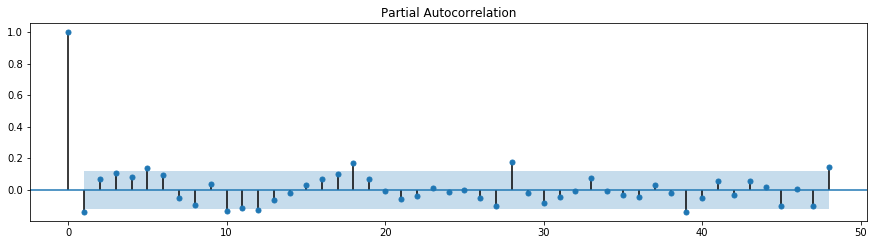

In [12]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(money.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(money.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Примем начальные приближения: Q=0, q=1, P=1, p=1.


In [43]:

ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [44]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Всего комбинаций параметров:", len(parameters_list))


Всего комбинаций параметров: 8


In [48]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(money.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print ('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 504 ms


In [49]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021911
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832


Лучшая модель:

In [50]:
print (best_model.summary())


                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Fri, 15 Feb 2019   AIC                              0.341
Time:                                    22:54:58   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Её остатки:

Критерий Стьюдента: p=0.090792
Критерий Дики-Фуллера: p=0.000003


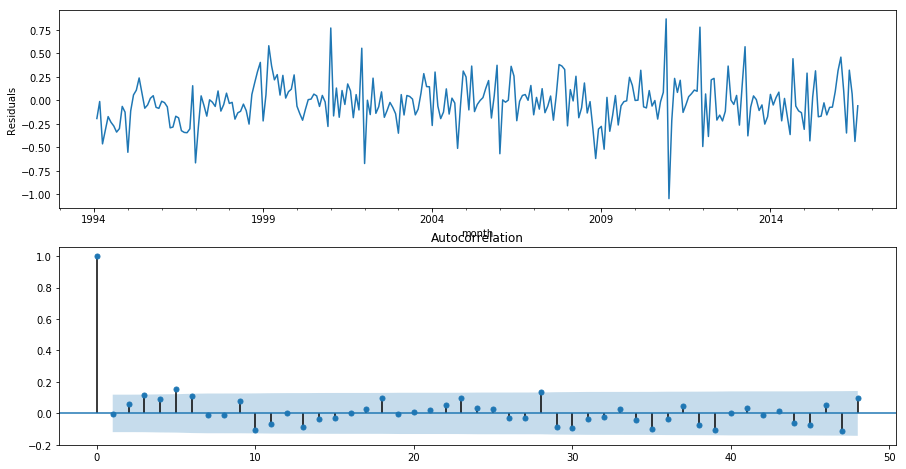

In [51]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:



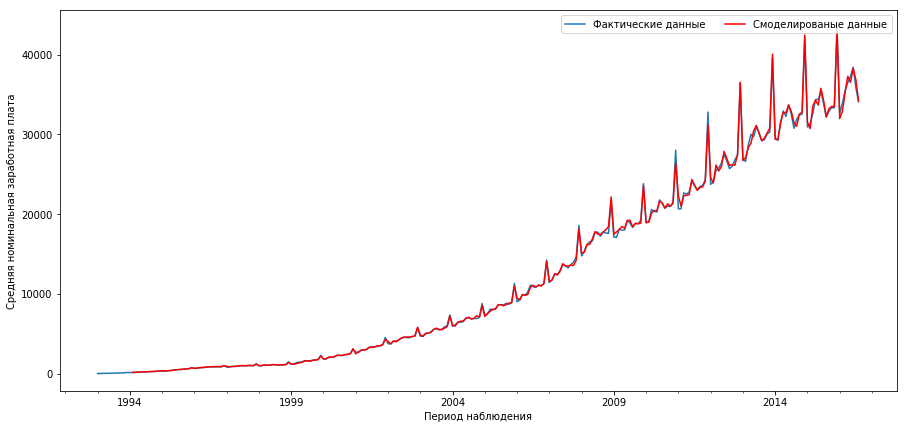

In [55]:
money['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
money.WAG_C_M.plot()
money.model[13:].plot(color='r')
plt.ylabel(u'Средняя номинальная заработная плата, руб.')
plt.xlabel(u'Период наблюдения')
plt.legend( [u'Фактические данные', u'Смоделированые данные'], loc=1, ncol = 2, prop={'size':10})

pylab.show()


#Прогноз

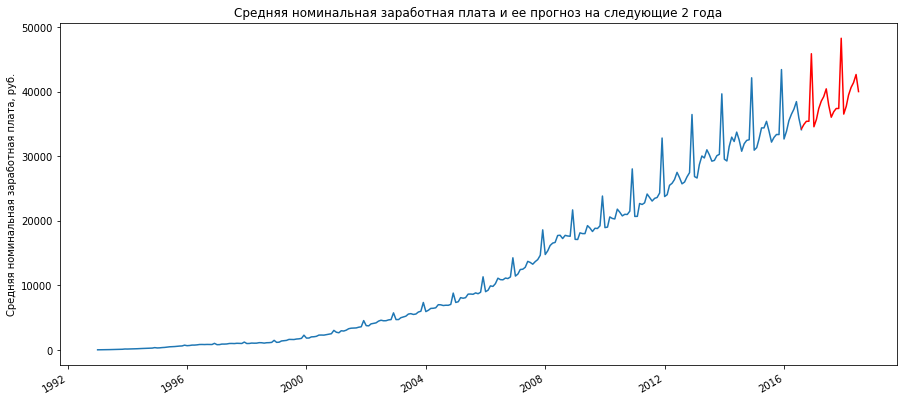

In [60]:
wage2 = money[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=283, end=320), lmbda)

plt.figure(figsize(15,7))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel(u'Средняя номинальная заработная плата, руб.')
plt.xlabel(u'Период наблюдения')
plt.title(u'Средняя номинальная заработная плата и ее прогноз на следующие 2 года')
pylab.show()
